# T7 - YAML calibration

As we saw in the earlier calibration tutorial, most autocalibrations involve multiple steps, since the optimization algorithm often gets stuck in local minima if we try to optimize too many parameters at once. We could run each of these steps ourselves through separate calls to `P.calibrate()` – however, there is significant value in being able to explicitly frame the overall calibration process as an algorithm, as this makes it easier to modify the calibration steps and apply the calibration algorithm across a collection of projects. This is implemented in Atomica through the 'YAML calibration' feature, in which the calibration steps are specified in a file which Atomica can then read and use to execute the calibration.

## YAML files

The calibration algorithm files used by Atomica are written in YAML. YAML is a plain-text, human-readable data serialization language used to make configuration files. Essentially, a YAML file can be read into Python variables (dictionaries, lists, strings) which in turn can be used as arguments to Python functions. Here is an example of how variables can be specified in a YAML file:

```
 foo: a string
 bar: 1
 baz: [a,b,c]
 list:
   - i
   - j
 nested:
   x: 1
   y: 2
 ```

When parsed into Python, this becomes

```
{'foo': 'a string',
 'bar': 1,
 'baz': ['a', 'b', 'c'],
 'list': ['i', 'j'],
 'nested': {'x': 1, 'y': 2}}
```

Using YAML files provides a simple way to define a calibration algorithm in a format that is easy to work with and that Atomica can directly execute. This can cut down the time we spend manually calibrating, or even running autocalibrations. It allows us to conduct reproducible calibration runs, and is also highly scalable, since it allows us to apply the same calibration algorithm in multiple countries or settings.

The following tutorial outlines how to use the YAML framework that has been developed for Atomica calibration. Specifically, it will cover how to write a YAML configuration file with calibration instructions for Atomica, and how to use this file to execute a calibration. Bear in mind that YAML calibration is not intended to be a standalone tool that will perfectly calibrate any model – rather, it is one part of the calibration toolbox. It can be used to reduce the time spent on calibration by autocalibrating Atomica models to a reasonable level, but additional tweaking may be required to obtain a consistently high calibration quality across all parameters, populations and/or countries.

## Basic calibration example

In this tutorial, we will work with a simple version of a typhoid model. This model captures typhoid infections, as well as asymptomatic carriers and vaccination. Firstly, we need to create an Atomica `Project` by loading in the Framework and Databook files, just like we did in [the first Atomica tutorial](https://atomica.tools/docs/master/tutorial/T1-Defining-a-model.html). The Framework and Databook for this project can be found in the Atomica repository under `T7/assets`.

In [1]:
import atomica as at
F = at.ProjectFramework('assets/T7_framework.xlsx')
D = at.ProjectData.from_spreadsheet('assets/T7_databook.xlsx', framework=F)
P = at.Project(framework=F, databook=D, do_run=False)
P.settings.update_time_vector(start=2000, end=2040, dt=1/52)

In the example above, no calibration has been loaded, so all the calibration Y-factors are equal to 1, and the model is uncalibrated. We can run a simulation and plot it, to see what our model looks like before calibration:

Elapsed time for running "default": 4.56s


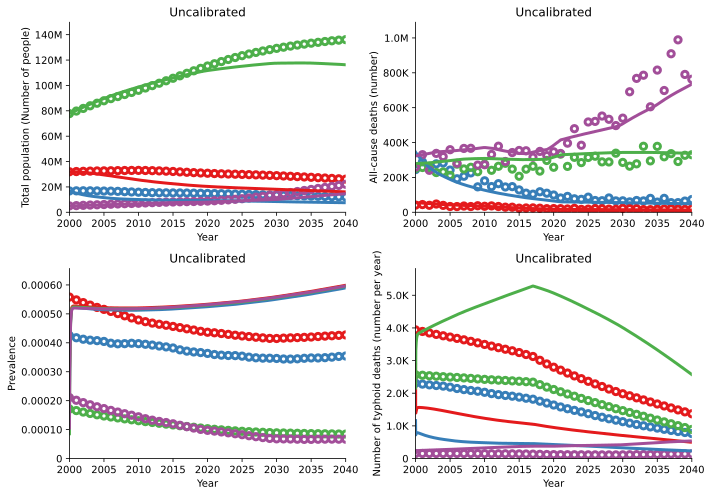

In [2]:
uncal = P.make_parset()
res = P.run_sim(parset=uncal, result_name='Uncalibrated')
d = at.PlotData(res, outputs=['alive','deaths', 'typ_prev', 'typ_num_deaths'], project=P)
fig = at.plot_series(d, axis='pops', data=P.data, n_cols=2, legend_mode='none')[0]
fig.set_size_inches(10,7)
fig.tight_layout()

Two issues with these simulation outputs immediately stand out. First, for the variables and years in which data is available, the model output doesn't match the data very well at all. Second, there is a large sudden change in the values of several variables right at the start of the simulation. In the absence of associated changes in interventions or disease transmission, disease burden is typically much more stable over time, so we would not expect to see such sudden changes at the start of the simulation.

Tutorial 2 covers some of the detail around how to approach calibration. Although the parameters used for calibration vary from model to model, as a general rule, calibration proceeds by

1. Demographic calibration: Adjusting birth and background death rates to match quantities like the total population size.
2. Epidemiological calibration: Adjusting parameters such as force of infection, diagnosis rate and mortality rate, to match quantities like incidence, prevalence and deaths.

Each of these steps involves calibrating multiple parameters, which may be adjusted sequentially and repeatedly. They may also be interspersed with adjusting the model's initialization, to help minimize sudden transients at the start of the simulation. The purpose of the YAML file is to specify the sequence of steps to follow in carrying out a calibration run, in terms of which parameters to adjust, the order in which to adjust them (or whether some should be adjusted simultaneously), and how to assess the quality of the calibration at each step of the process. In this tutorial, we will use YAML files to specify a sequence of steps to calibrate the simple typhoid model shown above, starting with a minimal example and then introducing key features provided by Atomica's YAML calibration system.

## Minimal YAML file

To illustrate how YAML calibration works, let’s start with a simple example of what a YAML file could look like:

    calibration:
    	adjustables: b_rate, mig_rate
    	measurables: alive

The above YAML file represents a single call to the autocalibration optimization function, where the `b_rate` and `mig_rate` y-factors are adjusted to match `alive`. It is equivalent to running a calibration with the following command:

    calibrated_parset = P.calibrate(parset = uncal, adjustables = ['b_rate', 'mig_rate'], measurables = 'alive')

Running the YAML calibration is very similar to performing a standalone auto-calibration. After saving the YAML file to disk (e.g., `T7_YAML_1_minimal.yaml`), the calibration can be run using

    calibrated_parset = P.calibrate(parset = uncal, yaml='T7_YAML_1_minimal.yaml')

As the YAML calibration framework allows us to specify the adjustables and measurables, it is not necessary to provide them to `Project.calibrate()` – simply providing the YAML file is sufficient. However, the YAML file can contain multiple calibration commands, and therefore a single call to `Project.calibrate()` with a YAML file might be equivalent to multiple explicit calibration steps. The resulting simulation after running this simple calibration is like so: 

<img src="assets/T7_plot_2_simple.png" alt="Simple calibration result" style="width: 800px;"/>
<img src="assets/T7_plot_1_simple_compare.png" alt="Simple calibration comparison" style="width: 450px;"/>

As you can see, these plots don't look very different to the uncalibrated simulation results. If we plot the uncalibrated simulation in the same plot as our simple calibration, we can see that there has been a slight change, but not nearly enough to be able to consider this a good calibration. Next, we will illustrate the YAML calibration features that we can use to improve on this initial result. 

## Sections

At the most basic level, a YAML calibration file defines a sequence of individual steps, where each step incrementally modifies the calibration. The YAML file therefore defines an overall _algorithm_ for performing an automatic calibration. This algorithm is defined using two structures in the YAML file:

- _actions_, which are associated with particular operations, like running a gradient-descent calibration step with a particular set of parameters and data. A calibration action contains `adjustables` and `measurables`. Other examples of actions are detailed below.
- _sections_, which are containers for actions. Sections can contain attributes, such as how many times to repeat the contents of the section, or they can define settings that are applied to any relevant actions within that section.

The original YAML file above consisted of a single calibration action. If we wanted to extend the algorithm by adding a step to calibrate the death rate, we could update our YAML file to the following: 


```
calibration:
    Match population sizes:
        adjustables: b_rate, mig_rate
        measurables: alive
    Match deaths:
        adjustables: d_rate
        measurables: deaths
```

To organize the YAML file further, we could group these into an additional section. Both of these actions affect the overall population calibration, so we could logically group them as follows:

```
calibration: 
    Population calibration:
        Match population sizes:
            adjustables: b_rate, mig_rate
            measurables: alive
        Match deaths:
            adjustables: d_rate
            measurables: deaths
```

The overall structure of this YAML file is thus:

1. A top-level section titled `calibration`, which has one sub-section (`Population calibration`)
2. A sub-section called `Population calibration`, which in turn contains two actions
3. An action called `Match population sizes`, corresponding to the original calibration step we used to adjust the birth rate and migration rate
4. An action called `Match deaths`, corresponding to the new step of adjusting the death rate

An action is differentiated from a section in two possible ways:

- By its contents (e.g. if it contains `adjustables` and `measurables`, then it will be interpreted as a calibration action rather than a section)
- By the title (if the name corresponds to the name of a supported operation, as described below)

Additionally, actions can never contain any sub-sections, whereas sections always do.
Apart from the names of supported operations, sections can be freely named.

### Repeating a section

The *repeats* keyword can be used to loop over any part of the calibration multiple times. We do this by writing `repeats: n` inside a particular section, where *n* is the number of times we would like to loop over that section. All subsections contained in it will also be looped over *n* times. 

    calibration: 
        repeats: 2
        Population calibration:
            Match population sizes:
                repeats: 2
                adjustables: b_rate, mig_rate
                measurables: alive
            Match deaths:
                adjustables: d_rate
                measurables: deaths

In the above example, we have set `repeats: 2` inside the `calibration` section, so the entire YAML calibration will be repeated twice. Then, the `Match population sizes` section also has `repeats: 2`, so the calibration step defined in that section will also be repeated twice each time. In total, there will be four calls to the optimization algorithm to match `alive`, and two to match `deaths, so the YAML file above would be equivalent to

    parset = P.calibrate(parset = parset, adjustables = [b_rate, mig_rate], measurables=alive)
    parset = P.calibrate(parset = parset, adjustables = [b_rate, mig_rate], measurables=alive)
    parset = P.calibrate(parset = parset, adjustables = [d_rate], measurables=deaths)
    parset = P.calibrate(parset = parset, adjustables = [b_rate, mig_rate], measurables=alive)
    parset = P.calibrate(parset = parset, adjustables = [b_rate, mig_rate], measurables=alive)
    parset = P.calibrate(parset = parset, adjustables = [d_rate], measurables=deaths)

In this way, it is possible for even a very compact YAML file to correspond to a large number of individual autocalibration steps. 

## Sections vs Actions

As shown above, sections can help us to structure the calibration in a way that is practical and intuitive. They can be used to group blocks of YAML code that are conceptually related, that we want to repeat together several times, or that we want to apply similar settings to (we will cover which settings are supported in [the corresponding section](#specifying-settings-in-outer-sections)).

Importantly though, _sections_ do not modify the calibration itself – they are merely wrappers for the innermost blocks that actually correspond to specific actions. It is in these _actions_ that operations are performed on the calibration, such as modifying the calibration or saving it.

<div class="alert alert-info">
We can tell action blocks apart from sections because action blocks contain keywords indicating what kind of block they are, and they don't contain any sub-sections.
</div>

It is possible to load and inspect a YAML file in Atomica without executing it. This can help confirm that the YAML file has been parsed correctly. After loading in the YAML file, it can be printed to show a summary of the sections and actions that are present, how they are nested, and how many times they are repeated: 

In [3]:
import atomica.yaml_calibration 
calibration_tree = at.yaml_calibration.build('calibrations/T7_YAML_3_repeats.yaml') 
print(calibration_tree)

<SectionNode "calibration" x1>
	<SectionNode "calibration" x2>
		<SectionNode "Population calibration" x1>
			<CalibrationNode "Match population sizes" x5>
			<CalibrationNode "Match deaths" x1>


## Types of Action Blocks

YAML calibration files can contain the following types of actions, or action blocks: 

- Calibration block
- Initialization block
- Intialization clearing block
- Saving block

### Calibration blocks

In all of the YAML examples shown above, we have worked with 'calibration blocks', which are the main type of action. Calibration blocks are defined by the fact that they contain the keywords `adjustables` and `measurables`. Under `adjustables`, we list the parameters for Atomica’s optimization algorithm to adjust, and under `measurables`, we list the parameters to calibrate to. Each calibration block provides instructions for one optimization run, and is equivalent to making one call to `P.calibrate()` with the same adjustables and measurables.

#### Adjustable and measurable settings

So far, we have only specified the names of the adjustables and measurables, with no further information – in that case, the optimization algorithm will use the default calibration settings for adjustables and measurables. For more flexibility, we can customise the settings that will be used for the optimization, which directly map to the options supported by `P.calibrate()`.

Each adjustable has:

- `adj_label` (required): Adjustable parameter codename (can be found in the framework)
- `pop_name`: Population to calibrate (default: all populations)
- `lower_bound`: Lowest value the y-factor will be allowed to take (default: 0.1)
- `upper_bound`: Highest value the y-factor will be allowed to take (default: 10)
- `starting_y_factor`: Y-factor value the optimization algorithm will start from (default: the adjustable's current `y_factor` in the parset)

Each measurable has:

- `meas_label` (required): Measurable parameter codename (can be found in the framework)
- `pop_name`: Population to use for calibration (default: all populations)
- `weight`: Weight for a particular population (default: 1). By default, all populations are weighted equally regardless of size. See [the documentation on weights](https://atomica.tools/docs/master/general/YAML_calibration.html#Measurable-Weights "Measurable weights") for further details.
- `metric`: Metric to be used by the optimization algorithm (default: fractional)
- `cal_start`: Starting year that the calibration will be evaluated from (default: `sim_start`)
- `cal_end`: End year until which the calibration will be evaluated (default: `sim_end`)

Note that `sim_start` and `sim_end` are the start and end years that the simulation will run for (the simulation timespan). These are distinct from `cal_start` and `cal_end`, which specify the time period for which we want to calibrate the model, i.e. a subset of the simulation timespan. For more information, see the [section on outer settings](#specifying-settings-in-outer-sections "Specifying settings in outer sections"). The `cal_start` and `cal_end` years can be set independently for each measurable, so it is possible to prioritize different years for different variables or for different steps of the calibration.
To specify these adjustables and measurables settings in the YAML file, we simply write the setting names and their values under the relevant parameter name. Each adjustable and measurable is placed on a new line, and their respective settings are also specified on separate indented lines, like so:

    calibration:
        Match population sizes:
            adjustables: 
            	b_rate: 
            		lower_bound: 0.5
            		upper_bound: 20		
            	mig_rate: 
            		starting_y_factor: 1.2 
            measurables: 
                alive:
                	cal_start: 2000
                	cal_end: 2040
                 

#### Specifying Populations

In some cases, we may only want to set adjustables or measurables for a specific population, or we may wish to use different settings for one population compared to another. A population can optionally be specified after the parameter name, as the second element of a tuple. Thus, if we only wish to calibrate some populations, we can rewrite our previous YAML file like so:

    calibration: 
        Match population sizes:
            adjustables: 
            	(b_rate, 0-4): 
            		lower_bound: 0.5
            		upper_bound: 20		
            	(mig_rate, 5-14): 
            		starting_y_factor: 1.2 
            measurables: 
                (alive, 0-4), (alive, 5-14):
                	cal_start: 2000
                	cal_end: 2040
       
Note that we can specify the same settings for more than one adjustable/measurable at once by placing several parameter names before the colon, separated by commas – this is applicable to any set of adjustables/measurables, not only different populations of the same parameter. For example, we could write: 

    calibration: 
        Match population sizes:
            adjustables: 
            	(b_rate, 0-4), mig_rate: 
            		lower_bound: 0.5
            		upper_bound: 20
                    starting_y_factor: 1.2		 
            measurables: 
                (alive, 0-4), (alive, 5-14):
                	cal_start: 2000
               	cal_end: 2040

Finally, the same syntax we use to calibrate populations can be used to calibrate transfers and interactions, but in such cases the tuple should have three elements - the parameter name, the _from_ population and the _to_ population. For more information on how to calibrate in these cases, see the documentation on [Calibrating transfers and interactions](https://atomica.tools/docs/master/general/YAML_calibration.html#Calibrating-transfers-and-interactions "Calibrating transfers and interactions").

### Setting initializations

In some cases, the model may exhibit an unrealistically large transient at the start of the simulation. This can occur if the initial compartment sizes calculated by Atomica are very different to the equilibrium compartment sizes associated with the model's parameters. Two common reasons for this are:

- The initial conditions are underdetermined, for example, if there are two strains of a disease with different levels of infectiousness, but data is only available on the total prevalence. In the absence of any other information, Atomica will automatically split up the total prevalence equally between the two strains, when in fact maybe one or the other strain may be dominant, which would change the overall transmission.
- The model parameters may not give rise to an equilibrium solution that matches the data. This could be due to data sources being mixed, combined across different years, collected in different ways or with different definitions, or because the simplified dynamics in the model simply don't capture all the processes in the real world.

Regardless of the cause, there can often be an initial transience period at the beginning of the simulation, where we can observe abrupt spikes in some parameters until the system reaches equilibrium. 

<img src="assets/fig_pre_init.png" alt="Pre-initialization plot" style="width: 400px;"/>

In some models, this can be treated as a 'burn-in' period, and the initial part of the simulation is simply discarded. However, there is a risk that being too far from the correct initialization can contaminate the parameter estimates during the calibration period. For example, if the model is initialized with the incorrect prevalence, the calibration applied to the force of infection in order to match the observed incidence would be impacted, which might subsequently affect the model's sensitivity to interventions that change the prevalence later on. Therefore, we wish to minimize the effect of transients on the calibration.

We can sometimes achieve this by setting the calibration start year `cal_start` to be a few years after the simulation start year `sim_start`, so that the simulation has a few years to reach equilibrium before the calibration process itself begins. However, this extends the duration of the simulation, and it might limit the amount of data that can be used for calibration.

An alternative approach is to override the initial values of our simulation and replace them with new initialization values. Setting an initialization works by running a normal Atomica simulation for a few years (past the initial transient), taking the compartment sizes of that future year, and setting the initial compartment sizes to those stabilized values. In cases where the model parameters are approximately constant, these future compartment sizes will be roughly equivalent to what the initial compartment sizes should be, which will prevent the appearance of an initial transient in the model.

<img src="assets/fig_post_init.png" alt="Post-initialization plot" style="width: 400px;"/>

If the model parameters are not roughly constant, the equilibrium that the model converges to in the future might not correspond to the equilibrium solution for the model's initial parameter values. In that case, an initial transient can still occur. To address this, we can remove any time variation in the model's parameter values using the `ParameterSet.make_constant()` method. This will return a copy of the parset in which all parameters are constant over time, thus ensuring that the future compartment sizes are computed based on the same parameter values as the initial simulation year. This often provides a suitable solution, although changes to the total population size due to births and deaths can still take place, so in some cases a small initial transient may still be present. In such cases, repeatedly setting initialization based on a shorter simulation can help minimize the discrepancy. For more information on Atomica initializations, see the [documentation on this topic](https://atomica.tools/docs/master/general/Compartment-Initialization.html "Initializing compartments").

In the YAML file, we indicate that we want to set a new initialization by making a YAML block with the title `set_initialization`. Under this title, we can specify further settings:

- `init_year` (required): The future year to take the compartment sizes from. The simulation will be run up to this year.
- `constant_parset` (default: False): Whether to make the parameters constant while the initialization is being calculated, and which year to extract these constant parameter values from, i.e. which year to use in `parset.make_constant()`. It can be a numerical value (representing the year from which to draw the constant values for the parset) or Boolean (if `True`, the default year `sim_start` will be used).

There are thus several valid ways to set an initialization. For example, only setting the initialization year:

```
calibration:
    set_initialization:
        init_year: 2030
```

Setting the initialization year with a constant parset, using the parameter values from the default `sim_start` year:

```
calibration:
    set_initialization:
        init_year: 2030
        constant_parset: True
```

Setting the initialization year with a constant parset, using constant parameter values from a specific year:


```
calibration:
    set_initialization:
        init_year: 2030
        constant_parset: 2005
```


### Clearing initializations

If we have previously set an initialization in our YAML calibration algorithm, and we then set another initialization later in the YAML file, it uses information from the previous initialization to calculate the next, since the new simulation will start from the initial compartment sizes calculated in that previous initialization.

Sometimes we might wish to calculate a new initialization from scratch, without using our previous initializations as a starting point. This could be useful if we have done some calibration steps between the previous initialization and now, in which case the y-factors will have changed, which in turn could have caused the equilibrium values to vary.

To do this in the YAML file, we can make a section titled `clear_initialization`, followed by a Boolean value. If it is set to `True`, any existing initialization will be cleared; if `False`, nothing will happen. The most simple example is as follows:

```
calibration:
    clear_initialization: True
```

Below is a more practical example of how we would use the `clear_initialization` feature in a real YAML file, where we first set an initialization, perform some calibration steps, and then clear our previous initialization before making a new one.

    calibration:
        First initialization:
            set_initialization:
                init_year: 2030

        Match population sizes:
            adjustables: b_rate, mig_rate
        	measurables: alive
        
    	clear_initialization: True

        Second initialization:
            set_initialization:
                init_year: 2030


Note that we need to wrap `set_initialization` in an outer section, since YAML does not allow duplicate keys (i.e. identical section/action titles at the same level).

### Saving calibrations

Throughout a YAML calibration, we might wish to save the calibration state at specific points in the process. For example, if our YAML file has a population section and an epidemiological section, we might want to save the calibration after the population calibration section so we can see the progress made up to that point, or otherwise identify the effect that different parts of the algorithm are having on the calibration. To save a calibration, we simply make a section titled `save_calibration`. Under the title, we indicate the filename we wish to save the calibration to, either by providing it directly, or by using the keyword `fname` - both examples are shown below:

    calibration:
    	Population section: 
    		[…]
    
    	save_calibration: 
    		fname: pop_calibration.xlsx
    
    	Epidemiology section: 
    		[…]

    	save_calibration: epi_calibration.xlsx
        
Note that when we save a calibration, if the initial compartment sizes have been explicitly specified using `set_initialization`, these compartment sizes will be saved along with the y-factors in the same Excel file. Loading the calibration from this file will thus also set the initial compartment sizes to those values.

Another option that can be useful for debugging is to save the calibration state at every intermediate step of the YAML file. In that case, we can use the `save_intermediate_calibrations` option when loading in and running the calibration, e.g.

    calibrated_parset = P.calibrate(parset = cal, yaml='T7_YAML_1_minimal.yaml', save_intermediate=True)

More options for running the calibration can be found [here](#running-the-yaml-calibration "Running the YAML calibration").

## Specifying settings in outer sections

We saw previously that sections (i.e. YAML blocks that don't correspond to actions) don't directly modify the calibration, and are mainly used to structure the YAML file. However, it is possible to determine calibration settings inside a section, such that they are passed down to any subsections or action blocks contained within. Another way to think of this is that an action block will inherit any settings that are defined in any of its parent sections.

This can simplify the process of writing YAML files where we want to override the default settings in several action blocks, as it allows us to specify those settings once in a parent section, rather than repeatedly in every action block. Additionally, this feature is hierarchical, so settings that are specified further in (e.g. in the action block itself) will always override those set in a section that is further out, allowing for more flexibility.

Some settings that this feature is commonly used for include: 

- `max_time`: Maximum amount of time each call to the optimization algorithm will run for (default: 60 seconds)
- `stepsize`: Initial step size, i.e. how much the y-factors will be increased/decreased by the optimization algorithm (default: 0.1)

Additionally, any adjustable or measurable setting can also be set outside of its calibration block, although some settings lend themselves more to this feature than others. For example, changing the measurable `weight` for an entire calibration block has no effect, as what matters is the proportion between the weights of different measurables in the same block. The following settings can be useful to set in parent sections:

- `cal_start` and `cal_end`: These can be used to change the calibration timespan for multiple calibration steps at the same time.
- `metric`: To change the metric used to assess calibration quality, i.e. how well the simulation fits the measurables data.

We will now provide some examples of how this functionality can be used.

### Inheritance

Settings are automatically inherited by all subsections. To set a `max_time` of 120 for every calibration step in the entire calibration, we would write the following. This will result in every calibration step running for at most 120 seconds, rather than the default 60 seconds.

    calibration:
        max_time: 120
        Population calibration:
            Match population sizes:
                adjustables: b_rate, mig_rate
                measurables: alive
            Match deaths:
                adjustables: d_rate
                measurables: deaths
        
        Epidemiological calibration
            [...]

### Settings hierarchy

Inherited settings can be overwritten inside subsections (in both sections and actions). Say we wanted all calibration blocks to run for a `max_time` of 120 seconds, except for `Match_deaths`, which we want to run for only 60 seconds. In that case, we can override the setting determined in the parent section by specifying the updated value inside `Match_deaths` subsection (which happens to be an action block):

    calibration:
        max_time: 120
        Population calibration:
            Match population sizes:
                adjustables: b_rate, mig_rate
                measurables: alive
            Match deaths:
                max_time: 60
                adjustables: d_rate
                measurables: deaths
        
        Epidemiological calibration
            [...]

### Outer adjustables/measurables settings

Finally, here is an example of how to use the adjustables and measurables settings outside a calibration block:

    calibration:
        Population calibration:
            upper_bound: 2
            lower_bound: 0.5

            Match population sizes:
                adjustables: b_rate, mig_rate
                measurables: alive

            Match deaths:
                    adjustables: d_rate
                    measurables: deaths

        Epidemiological calibration:
            [...]

In this case, the upper and lower bounds have been updated to 2 and 0.5 respectively, for all the adjustables in the `Population calibration` section (that is, `b_rate`, `mig_rate` and `d_rate`). The upper and lower bounds in the Epidemiological section will remain unchanged, using the default values of 0.1 and 10.

## Running the YAML calibration

Now that we have finished writing our YAML calibration file, we can proceed to running the calibration. Having loaded a project, `P.calibrate()` can then be called directly, passing in the uncalibrated parset and the name of the YAML file:

    calibrated_parset = P.calibrate(parset=uncal, yaml='T7_YAML_1_minimal.yaml')

This function also supports several optional arguments:

- `savedir`: Any saved calibrations and logs will be saved into this folder (default: current working directory).
- `save_intermediate`: If `True`, this will save a calibration file at every step (default: `False`).
- `max_time`: Maximum amount of time each calibration step will run for (default: 60 seconds).
- `log_output`: If `True`, this will save a text file into the output directory containing all console output, e.g. objective function values (default: `False`).

The YAML file can also be supplied as a dictionary, which would normally be obtained via

    import yaml
    yaml_instructions = yaml.load(file, Loader=yaml.FullLoader)
    
The `yaml_instructions` variable above can be passed to `P.calibrate(..., yaml=yaml_instructions)`. This enables changes to be made to the YAML content programmatically prior to running the calibration.

## Exercise: Worked Example

Now that we understand what all the working parts of a YAML file are, let's put it all together. For each question, write a YAML file to calibrate the model as described. Each question will consist of incremental additions to the previous solution.

_**Question 1.** We want to do a basic population calibration, where we calibrate the birth rate and migration rate to match the data corresponding to the total number of people alive. We also want to calibrate the death rate. What should this YAML file look like?_

**Hint**: Open the framework and look at the `Compartments`, `Parameters` and `Characteristics` pages. The `Code Names` and `Display Names` show us how we have to write the parameter names in the YAML file, and what quantities they correspond to. Those with a value in the `Databook Page` column have data values supplied, and can therefore be used as measurables.

**Hint 2**: Some of the parameter `Code Names` and `Display Names` in the databook are as follows: 

<table class="docutils align-default">  <thead>
    <tr>
      <th>Framework Sheet</th>
      <th>Code Name</th>
      <th>Display Name</th>
      <th>Databook Page</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="2">Compartments</td>
      <td>birth</td>
      <td>Birth</td>
      <td>none</td>
    </tr>
    <tr>
      <td>death</td>
      <td>Death</td>
      <td>none</td>
    </tr>
    <tr>
      <td rowspan="4">Parameters</td>
      <td>b_rate</td>
      <td>Birth rate</td>
      <td>demographic</td>
    </tr>
    <tr>
      <td>deaths</td>
      <td>All-cause deaths</td>
      <td>demographic</td>
    </tr>
    <tr>
      <td>d_rate</td>
      <td>Background mortality rate</td>
      <td>demographic</td>
    </tr>
    <tr>
      <td>mig_rate</td>
      <td>Migration Rate</td>
      <td>demographic</td>
    </tr>
    <tr>
      <td rowspan="1">Characteristics</td>
      <td>alive</td>
      <td>Total population</td>
      <td>demographic</td>
    </tr>
  </tbody>
</table>

_**Question 2.** A single calibration run may not be enough to get good results, so let's loop over our simple population calibration ten times. How would we make that change to the YAML file?_

**Hint**: Use the `repeats` keyword.

_**Question 3.** Say that, for this particular project, we are only interested in calibrating results from 2005 to 2040. How would we specify this in the YAML file to reduce calibration time?_

**Hint**: Using the `cal_start` and `cal_end` keywords.

_**Question 4.** When calibrating the birth rate, it only really makes sense to calibrate the 0-4 population. Modify the YAML file to reflect this._

**Hint**: We place the parameter code name and population name in a tuple.

_**Question 5.** Say we know that our data source underestimates the birth rate. Let’s set the starting y_factor for this parameter to 1.2 to speed up the optimization._

**Hint**: Use `starting_y_factor`.

_**Question 6.** We want to avoid the presence of transients in our calibrated simulation. Let’s initialize the calibration in order to eliminate any jumps._

**Hint**: Use `set_initialization` after the calibration blocks, and make sure the initialization gets re-calculated in every loop! 

_**Question 7.** We also want to clear the previous initialization every time we make a new one, instead of using information from the previous initialization. How can we update the YAML file to reflect this?_

**Hint**: Use `clear_initialization`, and make sure the initialization gets cleared and re-calculated in every loop!

_**Question 8.** We are almost ready to run the YAML calibration! Now, what instructions do we need to add to automatically save our population calibration once it is done?_

**Hint**: Use `save_calibration` and specify a `fname`.

All solutions to the worked example can be found in the `docs/tutorial/T7/calibrations` folder of the Atomica repository. The calibration obtained after running the last YAML file in this exercise yields the following simulation result:

<img src="assets/T7_plot_3_worked_example.png" alt="Worked example calibration result" style="width: 800px;"/>

The above calibration result is an improvement on the simple example shown earlier in the tutorial - while the simulation result for the 15-64 age group (in green) may not look as close to the data, the remaining populations have an excellent fit, leading to a very good overall population calibration. Additionally, all-cause deaths are now calibrated. Note that we do not expect the calibrated simulation to match the data points exactly, but to follow the same overall trends.

## Further resources

### Epidemiological calibration

In this tutorial we have demonstrated the key functionality of Atomica's YAML calibration system applied to a population calibration, focussing on adjusting births, migration and deaths to match population size data, without considering disease burden. The same functionality can be used for epidemiological calibration, just with different model parameters and data. A complete YAML file of the population and epidemiological calibration instructions can be found in the Atomica code repository, at `docs/tutorial/T7/calibrations/typ_calibration_instructions.yaml`.

In this YAML file, we have set the `max_time` to 120, to give the calibration a bit more time to reach an optimal solution in each calibration step. We then calibrate the population following the same principles illustrated previously, repeating the population calibration ten times, and setting a new initialization at the end of each loop, with `constant_parset=True` and the `init_year` set to 2030.

In the epidemiological calibration section, the typhoid incidence, prevalence, and typhoid deaths are calibrated. Since we don't have a lot of information on the order of magnitude of the susceptibility and infectiousness, the lower and upper bounds are expanded to leave more room for variation. However, we don't want the disease duration `typ_gen_dur` to vary a lot, since we have a pretty clear idea of its magnitude and don't want it to vary too much between calibrations and settings, so we set stricter bounds. 

At the end of the typhoid calibration, we set an initialization in the same way we did for the population calibration. We then repeat the epidemiological calibration ten times, and finally, repeat the whole YAML calibration process (except silencing the epi y-factors) twice.

The resulting calibration from running this YAML file is like so:

<img src="assets/T7_plot_4_complete.png" alt="Complete calibration result" style="width: 800px;"/>

As you can see, this is an improvement on the previous calibrations shown, since the epidemiological parameters (like typhoid prevalence and typhoid deaths) are now also calibrated to match the data.

__Alternative approach__

If the epidemiological parameters have a very large impact on the population parameters (for example, if the uncalibrated disease prevalence or disease mortality is much larger than the data would indicate), this can make it hard to properly calibrate the population in the first instance. We might observe that the population y-factors relating to births and migration increase (or, in the case of deaths, decrease) by a lot, to compensate for the large amount of people dying from disease.

To prevent this behaviour, we can do the following: At the beginning of the YAML file, we set the parameters relating to the typhoid disease (`typ_active_inf` and `typ_car`) to zero. This essentially "turns off" of the typhoid disease, giving us the opportunity to reasonably calibrate the population without interference from the disease components. Then, just after the population calibration section, we "reactivate" the disease by setting the `typ_active_inf` and `typ_car` y-factors back to 1, before proceeding to the epidemiological calibration. Looping over this whole algorithm a couple of times (except for the first step where we "turn off" the disease) allows the population to be fine-tuned while taking the epidemiological parameters into account.

### Documentation

For more information on using Atomica's YAML calibration functionality, see [the documentation](https://atomica.tools/docs/master/general/YAML_calibration.html "YAML documentation page").
